# 1. Functions

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

In [3]:
def print_time(begin_time, end_time):
    """ 
    This function prints the time in minutes that a certain task took.
    """
    print ("--------------------------------------------------")
    print ("CPU process time: %.2f [min]" % float((end-start)/60))
    print ("--------------------------------------------------")

# 2. Packages

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import arviz
import pystan
import time

In [2]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset_VOLLIM.csv')

In [5]:
np.unique(my_data['UV_CLASS'].values, return_counts=True)

(array(['UV_UPTURN', 'UV_WEAK'], dtype=object), array([41, 50]))

In [6]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# # parameters of interest
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
mass        = my_data['STELLAR_MASS'].values[index].astype(float)                  # 1st parameter
redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

In [7]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
n_obs   = x1.size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [8]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = 5                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['N'] = n_obs

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

### 2.1 Fit: STAN code 

In [9]:
stan_code = """
    data{
        int<lower=0> N;
        int<lower=0> N2;
        int<lower=0> K;
        int Y[N];
        matrix[N,K] X;
        matrix[N2,K] X2;
    }

    parameters{
        vector[K] beta;
    }

    transformed parameters{
        vector[N] eta;
        eta = X * beta;
    }

    model{
        Y ~ bernoulli_logit(eta);
    }

    generated quantities{
        vector[N2] etanew;
        real<lower=0, upper=1.0> pnew[N2];
        etanew = X2 * beta;
        for (j in 1:N2){
            pnew[j] = inv_logit(etanew[j]);
        }
    }
"""

### 2.2 Fit settings (for STAN)

In [10]:
iterations = 15000
chains     = 4                           # HMC chains
warmup     = 5000                        # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # Run code in parallel -- see pystan documentation
seed       = 1

In [11]:
control = {}
control['max_treedepth'] = 30
control['adapt_delta'] = 0.99

In [12]:
start = time.time()

model = pystan.StanModel(model_code=stan_code)

end = time.time()
print_time(start, end)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9aeae9f053f6674eec0d58f69781a4c9 NOW.


--------------------------------------------------
CPU process time: 1.26 [min]
--------------------------------------------------


### 2.3 Running the fit

In [13]:
start = time.time()

fit = model.sampling(data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup, n_jobs=jobs, 
                     control=control)
end = time.time()
print_time(start, end)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--------------------------------------------------
CPU process time: 3.45 [min]
--------------------------------------------------


# 3. Retrieving the data from the fit

### 3.1 Saving the entire fit: brace for impact!

In [14]:
start  = time.time()
fit_df = fit.to_dataframe()
end    = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 0.10 [min]
--------------------------------------------------


In [15]:
start = time.time()
fit_df.to_csv('../../LargeFilesResults/Model/entirefit_noemlines_VOLLIM.csv', index=False)
end   = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 2.47 [min]
--------------------------------------------------


In [16]:
posteriors = fit_df[fit.flatnames[:5]]
header_posteriors = fit.flatnames[:5]

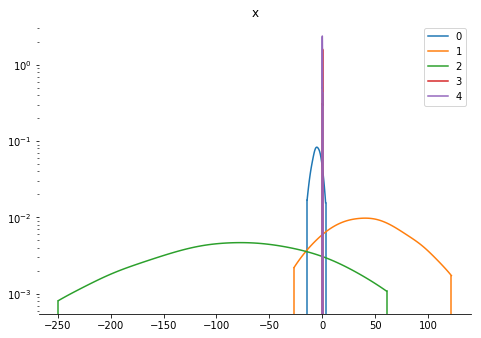

In [17]:
arviz.plot_density(data=[fit['beta[1]'], fit['beta[2]'], fit['beta[3]'], fit['beta[4]'], fit['beta[5]']])
plt.yscale('log')
plt.show()

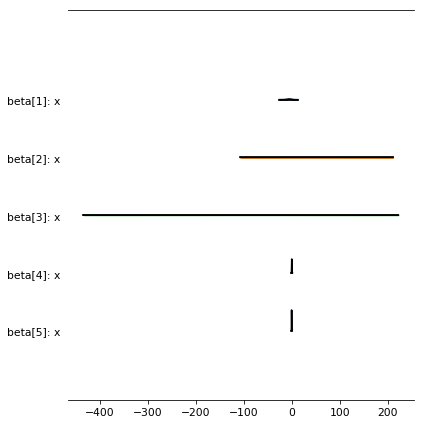

In [18]:
arviz.plot_forest(data=[fit['beta[1]'], fit['beta[2]'], fit['beta[3]'], fit['beta[4]'], fit['beta[5]']], 
                  kind='ridgeplot', model_names=['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'],
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest05_VOLLIM.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
figsize=(6,3)

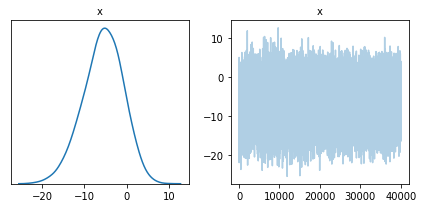

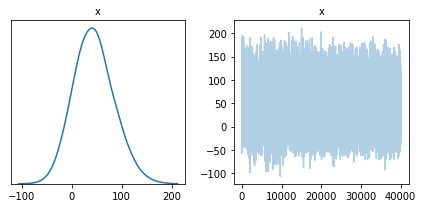

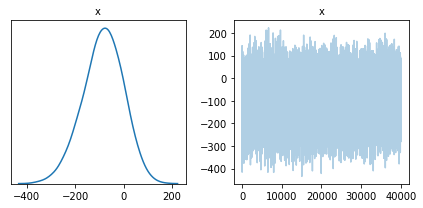

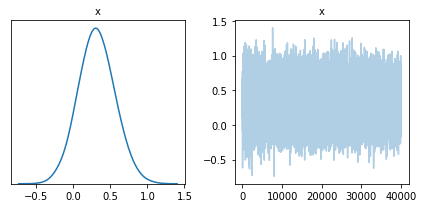

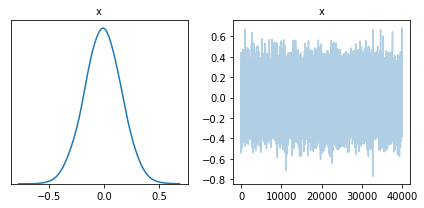

In [20]:
plot = arviz.plot_trace(data=fit['beta[1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5]'], figsize=figsize)
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/trace_class01_VOLLIM.pdf', bbox_inches='tight')
plt.show()

### 3.2 Saving the automatic summary from STAN

In [21]:
summary = pystan.stansummary(fit=fit, digits_summary=4)

In [22]:
summary_arr  = np.array(summary.split('\n'))
summary_clean = summary_arr[5:-6,]

In [23]:
header_fit = ['parameter'] + summary_arr[4].split()

#### 3.2.1 Recovering the mass (undo the stadardization) and adding x1 and x2 to the summary

In [24]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
recovered_pars  = np.column_stack((np.squeeze(plot_x1), np.squeeze(recovered_mass)))
rp = recovered_pars

In [62]:
rp

array([[ 0.08843   , 10.79542   ],
       [ 0.09739103, 10.79542   ],
       [ 0.10635207, 10.79542   ],
       ...,
       [ 0.33037793, 11.56326   ],
       [ 0.33933897, 11.56326   ],
       [ 0.3483    , 11.56326   ]])

#### 3.2.2 Checking if the numbers aren't overlaped

In [66]:
new_summary = list(np.zeros(len(header_fit)))
# print (summary_clean.size)
for i in range(summary_clean.size):
    if len(summary_clean[i].split())!=11:  # the length of the list must be 11, in which case we connect them directly
        addendum = np.array(np.zeros(11-len(summary_clean[i].split())))
        new_summ_temp = np.concatenate((summary_clean[i].split(), addendum))
        new_summary   = np.vstack((new_summary, new_summ_temp))
#         print (len(summary_clean[i].split()))
        print ('new_summary[%d] = ' %i, "%s" % new_summ_temp)
#         print (addendum)
#         print (new_summary)
    else:
        new_summ_temp = np.array(summary_clean[i].split()).reshape(1,11)
        new_summary   = np.vstack((new_summary, new_summ_temp))
new_summary = new_summary[1:,:]            # removing the zeroes in the beggining

new_summary[1] =  ['beta[2]' '43.925' '0.4011' '40.085' '-29.26' '16.089' '42.201'
 '69.6341.271e2' '9987' '1.0' '0.0']
new_summary[2] =  ['beta[3]' '-85.54' '0.8395' '84.067-2.595e2-1.396e2' '-82.06' '-27.20'
 '69.627' '10029' '1.0' '0.0' '0.0']


In [67]:
new_summary[1] = ['beta[2]', '43.925', '0.4011', '40.085', '-29.26', '16.089', '42.201', '69.634', '1.271e2', '9987', 
                  '1.0']
new_summary[2] = ['beta[3]', '-85.54', '0.8395', '84.067', '-2.595e2', '-1.396e2', '-82.06', '-27.20', '69.627', 
                  '10029', '1.0']

#### 3.2.3 Retrieving only the probabilities from the summary and stacking x1 and x2 at the end of the dataframe

In [68]:
new_summary

array([['beta[1]', '-5.622', '0.0467', ..., '2.9243', '10143', '1.0'],
       ['beta[2]', '43.925', '0.4011', ..., '1.271e2', '9987', '1.0'],
       ['beta[3]', '-85.54', '0.8395', ..., '69.627', '10029', '1.0'],
       ...,
       ['pnew[898]', '0.5631', '0.0014', ..., '0.9252', '24507',
        '0.9999'],
       ['pnew[899]', '0.5392', '0.0014', ..., '0.9183', '24946',
        '0.9999'],
       ['pnew[900]', '0.5126', '0.0015', ..., '0.9153', '23898',
        '0.9999']], dtype='<U32')

In [78]:
probs = new_summary[996:1992,:]

In [83]:
print(probs.shape, rp.shape)

(900, 11) (900, 2)


In [84]:
tosave = np.column_stack([probs, rp])

In [85]:
probs = pd.DataFrame(tosave)

In [100]:
model_results_df = pd.DataFrame(tosave)
model_results_df.columns = header_fit + ['Z', 'LOG_STELLAR_MASS']
model_results_df.to_csv('../../LargeFilesResults/Model/fit_summ_noemlines_VOLLIM.csv', header=True, index=False)

In [87]:
model_results_df

,parameter,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat,Z,LOG_STELLAR_MASS
0,pnew[1],0.1099,0.0013,0.161,0.0006,0.0103,0.0406,0.136,0.6147,16199,1.0001,0.08843,10.79542
1,pnew[2],0.1172,0.0012,0.1585,0.0011,0.0148,0.0509,0.1521,0.6053,16663,1.0001,0.09739103448275861,10.79542
2,pnew[3],0.1262,0.0012,0.1571,0.0019,0.0205,0.0629,0.17,0.5942,17211,1.0001,0.10635206896551724,10.79542
3,pnew[4],0.1369,0.0012,0.1567,0.0031,0.0277,0.0767,0.1883,0.592,17854,1.0001,0.11531310344827586,10.79542
4,pnew[5],0.1494,0.0012,0.1574,0.005,0.0365,0.0925,0.2083,0.5935,18594,1.0001,0.12427413793103448,10.79542
5,pnew[6],0.1638,0.0011,0.1593,0.0075,0.0467,0.1097,0.2294,0.6014,19409,1.0001,0.1332351724137931,10.79542
6,pnew[7],0.1797,0.0011,0.1621,0.0105,0.0582,0.128,0.2539,0.6124,20244,1.0001,0.1421962068965517,10.79542
7,pnew[8],0.197,0.0011,0.166,0.0139,0.0701,0.1476,0.2793,0.6271,20998,1.0001,0.15115724137931036,10.79542
8,pnew[9],0.2152,0.0012,0.1706,0.0176,0.0828,0.1677,0.3046,0.6487,21546,1.0001,0.16011827586206895,10.79542
9,pnew[10],0.2338,0.0012,0.1759,0.0212,0.0958,0.1885,0.3322,0.6699,21787,1.0001,0.1690793103448276,10.79542


In [88]:
posteriors = fit_df[fit.flatnames[:5]]

In [89]:
fit_df.keys()

Index(['chain', 'draw', 'warmup', 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]',
       'beta[5]', 'eta[1]', 'eta[2]',
       ...
       'pnew[898]', 'pnew[899]', 'pnew[900]', 'lp__', 'accept_stat__',
       'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'],
      dtype='object', length=1906)

In [90]:
fit_df['treedepth__'].describe()

count    40000.000000
mean         7.983025
std          1.478205
min          2.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         10.000000
Name: treedepth__, dtype: float64

In [91]:
fit_df['n_leapfrog__'].describe()

count    40000.000000
mean       469.477250
std        307.756656
min          3.000000
25%        255.000000
50%        511.000000
75%        511.000000
max       2047.000000
Name: n_leapfrog__, dtype: float64

In [94]:
posteriors.to_csv('../../LargeFilesResults/Model/posteriors_noemlines_VOLLIM.csv', index=False)

In [95]:
posteriors

,beta[1],beta[2],beta[3],beta[4],beta[5]
0,-2.390343,18.629456,-36.630025,-0.013410,-0.074011
1,-4.078011,27.669783,-46.181579,0.496415,-0.061276
2,-3.738577,35.052441,-78.875118,0.486395,-0.088828
3,-0.567599,4.752729,-13.578158,0.390555,-0.053574
4,-10.238683,88.005966,-182.226735,0.453887,-0.000808
5,-7.250085,58.232674,-108.338840,0.242392,-0.125734
6,-7.918050,60.421518,-107.010458,0.163529,-0.151866
7,-8.158284,62.397333,-117.638472,0.067458,0.152813
8,-4.671546,31.582968,-52.923246,0.036321,0.154480
9,-5.554786,49.270823,-111.221918,0.378756,0.378351


In [96]:
diagnostics = pystan.check_hmc_diagnostics(fit, per_chain=True)

In [97]:
diagnostics

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [98]:
model_results_df['Rhat'].max()

'1.0003'

In [99]:
model_results_df['Rhat'].min()

'0.9999'